<a href="https://colab.research.google.com/github/HyunMiPark/study_AI/blob/main/%5B5%EC%A3%BC%EC%B0%A8%5D_%EA%B8%B0%EB%B3%B8%EA%B3%BC%EC%A0%9C_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install langchain-community langchain-chroma langchain-openai bs4

In [6]:
import bs4
import os
from getpass import getpass
from langchain import hub
from langchain_chroma import Chroma
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [7]:
# ✅ 키 입력 받아 환경변수로 저장
os.environ["OPENAI_API_KEY"] = getpass("🔑 Enter your OpenAI API key: ")

llm = ChatOpenAI(model="gpt-4o-mini", openai_api_key=os.environ["OPENAI_API_KEY"])

🔑 Enter your OpenAI API key: ··········


In [14]:
loader = WebBaseLoader(
    web_paths=("https://spartacodingclub.kr/blog/all-in-challenge_winner",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("editedContent")
        )
    ),
)
docs = loader.load()

In [16]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200
)
splits = text_splitter.split_documents(docs)
vectorstore = Chroma.from_documents(
    documents=splits,
    embedding=OpenAIEmbeddings(openai_api_key=os.environ["OPENAI_API_KEY"])
)

In [17]:
retriever = vectorstore.as_retriever()

user_msg = "ALL-in 코딩 공모전 수상작들을 요약해줘."
retrieved_docs = retriever.invoke(user_msg)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)
prompt = hub.pull("rlm/rag-prompt")

user_prompt = prompt.invoke({"context": format_docs(retrieved_docs), "question": user_msg})
print(user_prompt)

/usr/local/lib/python3.11/dist-packages/langsmith/client.py:271: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


messages=[HumanMessage(content="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: ALL-in 코딩 공모전 수상작들을 요약해줘. \nContext: ì„œë¹„ìŠ¤ë¥¼ ë§Œë‚˜ë³´ê³\xa0 ì‹¶ë‹¤ë©´?ë‹¤ì–‘í•œ ì„œë¹„ìŠ¤ì™€ ê¸°ë°œí•œ ì•„ì�´ë””ì–´ê°€ ëª¨ì�¸ ê³³ì—� ì´ˆëŒ€í•©ë‹ˆë‹¤. ì°¸ê°€ì��ë“¤ì�˜ ë¬¸ì\xa0œ í•´ê²°ë°©ë²•ì�´ ê¶�ê¸ˆí•˜ì‹œë‹¤ë©´ ì§€ê¸ˆ ë°”ë¡œ â€˜All-in ê³µëª¨ì\xa0„â€™ì—�ì„œ ë§Œë‚˜ë³´ì„¸ìš”!ğŸ‘‰ğŸ�»Â\xa0ê³µëª¨ì\xa0„ ê²°ê³¼ë¬¼ ë³´ëŸ¬ê°€ê¸°ëˆ„êµ¬ë‚˜ í�°ì�¼ ë‚¼ ìˆ˜ ì�ˆì–´ìŠ¤íŒŒë¥´íƒ€ì½”ë”©í�´ëŸ½ê¸€ | ì‹\xa0ìˆ˜ì§€ íŒ€ìŠ¤íŒŒë¥´íƒ€ ì—�ë””í„°\n\nSpring Boot, MySQL, Spring WebSocket-BE(ë°±ì—”ë“œ): React Native, TanStack Query, Axiosì½”ë”© ê³µëª¨ì\xa0„ ìˆ˜ìƒ�ì�‘ì�€ ëŒ€í•™ìƒ�ë“¤ì�˜ íŒ€í”„ë¡œì\xa0�íŠ¸ë¥¼ í†µí•´ ë§Œë“¤ì–´ì§„ ì›¹/ì•± ì„œë¹„ìŠ¤ì�…ë‹ˆë‹¤. ìº\xa0í�¼ìŠ¤ì—�ì„œì�˜ ë¬¸ì\xa0œë¥¼ í•´ê²°í•˜ì��ëŠ” ì°¸ê°€ì��ë“¤ì�˜ ì•„ì�´ë””ì–´ì—�ì

In [18]:
response = llm.invoke(user_prompt)
print(response.content)

모든 코딩 공모전 수상작들은 다양한 기술 스택을 활용하여 독창적인 프로젝트를 선보였습니다. 예를 들어, Spring Boot와 MySQL을 활용한 백엔드와 React Native로 개발된 모바일 애플리케이션이 주를 이룹니다. 또한, 수상작들은 실용성과 혁신성을 바탕으로 평가되어 높은 점수를 받았습니다.


🔍 RAG 내부 흐름 시각화
1. 문서 조각 수	전체 로드된 문서가 몇 조각(splits)으로 나뉘었는지
2. 벡터 유사도 점수	사용자 질문과 가장 가까운 문서들의 점수 시각화
3. 검색된 문서 내용 미리보기	검색된 top-k 문서를 테이블이나 목록으로 정리

In [24]:
!pip install ftfy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.2 MB/s eta 0:00:00


In [26]:
import html
import codecs

from ftfy import fix_text

df = pd.DataFrame([{
    "Index": i+1,
    "Score": round(score, 4),
    "Preview": fix_text(doc.page_content[:150]).replace("\n", " ") + "..."
} for i, (doc, score) in enumerate(docs_with_scores)])

display(df)

,Index,Score,Preview
0,1,0.4641,"서비스를 만나보고 싶다면?다양한 서비스와 기발한 ì•""ì�´ë""""ì–´ê°€ 모ì�..."
1,2,0.4796,"Spring Boot, MySQL, Spring WebSocket-BE(백엔드): ..."
2,3,0.4802,"�어져 �고, 신뢰할 만한 정보를 찾기 어려웠습니다.<Crewing>� 대학�들� ..."
3,4,0.4918,"기술 스íƒ� -FE(프론트엔드): Spring Boot, Redis, MySQL-..."
4,5,0.4970,대한 피드백� 받� 수 �는 �가 기능과 학�� �해�를 테스트 할 수 �는 퀴즈 ...


📊 문서 임베딩 분포 시각화 (2D)
1. 벡터들을 PCA / t-SNE로 2D로 축소해 플롯
2. 어떤 문서가 질문과 가까운지 시각적으로 확인 가능

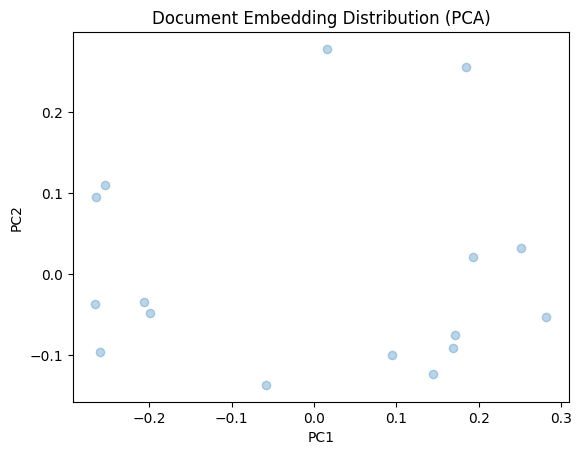

In [27]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 전체 문서 벡터 추출
all_docs = vectorstore._collection.get(include=['embeddings'])  # Chroma 내부 구조 접근
vectors = all_docs['embeddings']

# PCA로 2차원 축소
pca = PCA(n_components=2)
reduced = pca.fit_transform(vectors)

# 시각화
plt.scatter(reduced[:, 0], reduced[:, 1], alpha=0.3)
plt.title("Document Embedding Distribution (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [28]:
for i, doc in enumerate(retrieved_docs):
    print(f"\n--- Retrieved Doc #{i+1} ---")
    print(doc.page_content[:300] + "...")
print(f"\n--- Final LLM Response ---\n{response.content}")


--- Retrieved Doc #1 ---
ì„œë¹„ìŠ¤ë¥¼ ë§Œë‚˜ë³´ê³  ì‹¶ë‹¤ë©´?ë‹¤ì–‘í•œ ì„œë¹„ìŠ¤ì™€ ê¸°ë°œí•œ ì•„ì�´ë””ì–´ê°€ ëª¨ì�¸ ê³³ì—� ì´ˆëŒ€í•©ë‹ˆë‹¤. ì°¸ê°€ì��ë“¤ì�˜ ë¬¸ì œ í•´ê²°ë°©ë²•ì�´ ê¶�ê¸ˆí•˜ì‹œë‹¤ë©´ ì§€ê¸ˆ ë°”ë¡œ â€˜All-in ê³µëª¨ì „â€™ì—�ì„œ ë§Œë‚˜ë³´ì„¸ìš”!ğŸ‘‰ğŸ�»Â ê³µëª¨ì „ ê²°ê³¼ë¬¼ ë³´ëŸ¬ê°€ê¸°ëˆ„êµ¬ë‚˜ í�°ì�¼ ë‚¼ ìˆ˜ ...

--- Retrieved Doc #2 ---
Spring Boot, MySQL, Spring WebSocket-BE(ë°±ì—”ë“œ): React Native, TanStack Query, Axiosì½”ë”© ê³µëª¨ì „ ìˆ˜ìƒ�ì�‘ì�€ ëŒ€í•™ìƒ�ë“¤ì�˜ íŒ€í”„ë¡œì �íŠ¸ë¥¼ í†µí•´ ë§Œë“¤ì–´ì§„ ì›¹/ì•± ì„œë¹„ìŠ¤ì�…ë‹ˆë‹¤. ìº í�¼ìŠ¤ì—�ì„œì�˜ ë¬¸ì œë¥¼ í•´ê²°í•˜ì��ëŠ” ì°¸ê°€ì��ë“¤ì�˜ ì•„ì�´ë””ì–´ì—�ì„œ ì‹œì�‘ë�˜ì—ˆì£ . ëˆ„...

--- Retrieved Doc #3 ---
í�©ì–´ì ¸ ì�ˆê³ , ì‹ ë¢°í•  ë§Œí•œ ì •ë³´ë¥¼ ì°¾ê¸° ì–´ë ¤ì› ìŠµë‹ˆë‹¤.<Crewing>ì�€ ëŒ€í•™ìƒ�ë“¤ì�´ ë‹¤ì–‘í•œ ì—°í•© ë�™ì•„ë¦¬ì—� ì‰½ê²Œ ê°€ì�…í•˜ê³ , ì �ì ˆí•œ ë�™ì•„ë¦¬ë¥¼ ì°¾ì�„ ìˆ˜ ì�ˆë�„ë¡� ì§€ì›�í•´ì£¼ëŠ” ì•„ì¹´ì�´ë¹™ í”Œë�«í�¼ì�…ë‹ˆë‹¤. íšŒì›�ê°€ì�… ì‹œ ìƒ�ë…„, ì„±ë³„, ê´€ì‹¬ ë¶„ì•¼ë¥¼ ì�…ë ¥...

--- Retri